<a href="https://colab.research.google.com/github/gourabdatta2384/Python_basics_191-15-2384/blob/main/DenseNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Necessary Libraries

In [ ]:
!pip install keras
!pip install keras-tuner

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Data Input

In [ ]:
# Paths for original data and the new directories after splitting
dataset_dir = r'G:\Projects & Developments\Python\my_env\code\Face Diseases Detection\DATA'  # Replace with your dataset directory
train_dir = r'G:\Projects & Developments\Python\my_env\code\Face Diseases Detection\Data Splitting\TRAIN'
validation_dir = r'G:\Projects & Developments\Python\my_env\code\Face Diseases Detection\Data Splitting\VALIDATION'
test_dir = r'G:\Projects & Developments\Python\my_env\code\Face Diseases Detection\Data Splitting\TEST'

## Data Preprocessing

In [ ]:
# Function to split data into train, validation, and test directories
def split_data(dataset_dir, train_dir, validation_dir, test_dir):
    # List the class directories
    class_names = os.listdir(dataset_dir)

    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            # Create directories for class in train, test, and validation directories
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # List all images in the class directory
            images = os.listdir(class_dir)
            train_images, temp_images = train_test_split(images, train_size=0.7, random_state=42)
            test_images, validation_images = train_test_split(temp_images, test_size=0.2857, random_state=42)

            # Move images to respective directories
            for image in train_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(train_dir, class_name, image))
            for image in validation_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(validation_dir, class_name, image))
            for image in test_images:
                shutil.copy(os.path.join(class_dir, image), os.path.join(test_dir, class_name, image))
            print(f"Class {class_name}: {len(train_images)} training, {len(validation_images)} validation, {len(test_images)} test images.")


In [ ]:
# Split the dataset
split_data(dataset_dir, train_dir, validation_dir, test_dir)

Class Acne: 2100 training, 258 validation, 642 test images.
Class Actinic Keratosis: 2100 training, 258 validation, 642 test images.
Class Basal Cell Carcinoma: 2100 training, 258 validation, 642 test images.
Class Eczemaa: 2100 training, 258 validation, 642 test images.
Class Rosacea: 2100 training, 258 validation, 642 test images.


In [ ]:
# Initialize ImageDataGenerator for train, validation, and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create data generators for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

Found 10500 images belonging to 5 classes.
Found 1290 images belonging to 5 classes.
Found 3210 images belonging to 5 classes.


## Feature Extraction

In [ ]:
# Define the hypermodel with Keras Tuner for hyperparameter optimization
def build_hypermodel(hp):
    DenseNet121_Base = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
    )
    DenseNet121_Base.trainable = False  # Freeze the NASNetLarge base

    model = tf.keras.models.Sequential([
        DenseNet121_Base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.8, step=0.1)),
        tf.keras.layers.Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256), activation='relu'),
        tf.keras.layers.Dense(units=hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'),
        tf.keras.layers.Dense(units=len(train_generator.class_indices), activation='softmax'),
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Applying Keras Tuner

In [ ]:
# Hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='tuning_dir',
    project_name='DenseNet121_tuning'
)


In [ ]:
# Perform the hyperparameter search
tuner.search(
    train_generator,
    validation_data=validation_generator,
    batch_size=32,
    epochs=15
)

Trial 10 Complete [00h 22m 13s]
val_accuracy: 0.9519379734992981

Best val_accuracy So Far: 0.9689922332763672
Total elapsed time: 04h 06m 21s


In [ ]:
# Get the best hyperparameters and build the final model
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)



In [ ]:
tuner.results_summary()

Results summary
Results in tuning_dir\DenseNet121_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
dropout: 0.5
units: 768
Score: 0.9689922332763672

Trial 01 summary
Hyperparameters:
dropout: 0.7
units: 768
Score: 0.9627906680107117

Trial 08 summary
Hyperparameters:
dropout: 0.7
units: 1024
Score: 0.9620155096054077

Trial 05 summary
Hyperparameters:
dropout: 0.4
units: 256
Score: 0.961240291595459

Trial 02 summary
Hyperparameters:
dropout: 0.6000000000000001
units: 256
Score: 0.9589147567749023

Trial 07 summary
Hyperparameters:
dropout: 0.5
units: 256
Score: 0.9573643207550049

Trial 03 summary
Hyperparameters:
dropout: 0.2
units: 512
Score: 0.9565891623497009

Trial 04 summary
Hyperparameters:
dropout: 0.6000000000000001
units: 768
Score: 0.9542635679244995

Trial 06 summary
Hyperparameters:
dropout: 0.30000000000000004
units: 256
Score: 0.9542635679244995

Trial 09 summary
Hyperparameters:
dropout: 0.4
units: 512
Sc

In [ ]:
# Train the final model
history = best_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
)

Epoch 1/30
329/329 [==============================] - 89s 262ms/step - loss: 1.3814 - accuracy: 0.7111 - val_loss: 0.3957 - val_accuracy: 0.8612
Epoch 2/30
329/329 [==============================] - 86s 260ms/step - loss: 0.4690 - accuracy: 0.8270 - val_loss: 0.3554 - val_accuracy: 0.8690
Epoch 3/30
329/329 [==============================] - 86s 260ms/step - loss: 0.3620 - accuracy: 0.8690 - val_loss: 0.2199 - val_accuracy: 0.9178
Epoch 4/30
329/329 [==============================] - 85s 259ms/step - loss: 0.3069 - accuracy: 0.8889 - val_loss: 0.2215 - val_accuracy: 0.9155
Epoch 5/30
329/329 [==============================] - 86s 260ms/step - loss: 0.2567 - accuracy: 0.9076 - val_loss: 0.2363 - val_accuracy: 0.9233
Epoch 6/30
329/329 [==============================] - 85s 260ms/step - loss: 0.2435 - accuracy: 0.9167 - val_loss: 0.1783 - val_accuracy: 0.9388
Epoch 7/30
329/329 [==============================] - 86s 260ms/step - loss: 0.2063 - accuracy: 0.9280 - val_loss: 0.1492 - val_ac

In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


101/101 [==============================] - 25s 243ms/step - loss: 0.0743 - accuracy: 0.9773
Test Accuracy: 0.977258563041687
Test Loss: 0.07433371990919113


In [ ]:
# Optional: Check class indices
print(test_generator.class_indices)

{'Acne': 0, 'Actinic Keratosis': 1, 'Basal Cell Carcinoma': 2, 'Eczemaa': 3, 'Rosacea': 4}


In [ ]:
import numpy as np
from sklearn import metrics

predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels = ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

101/101 [==============================] - 11s 101ms/step
                      precision    recall  f1-score   support

                Acne       0.99      0.98      0.98       642
   Actinic Keratosis       0.98      0.97      0.97       642
Basal Cell Carcinoma       0.99      0.98      0.98       642
             Eczemaa       0.98      0.99      0.98       642
             Rosacea       0.95      0.98      0.97       642

            accuracy                           0.98      3210
           macro avg       0.98      0.98      0.98      3210
        weighted avg       0.98      0.98      0.98      3210



<AxesSubplot:>

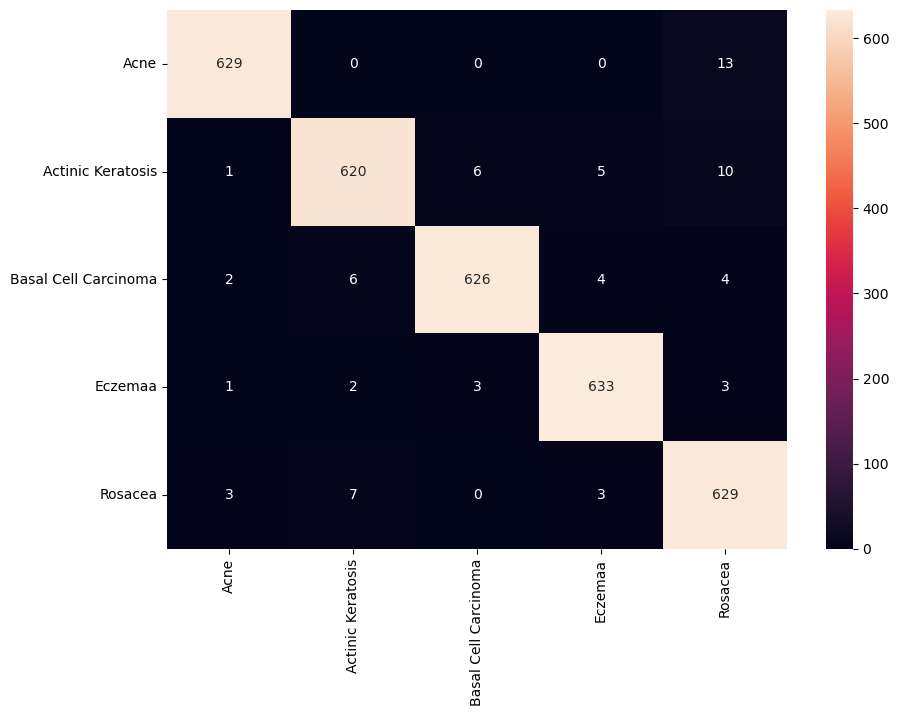

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']],
                  columns = [i for i in ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

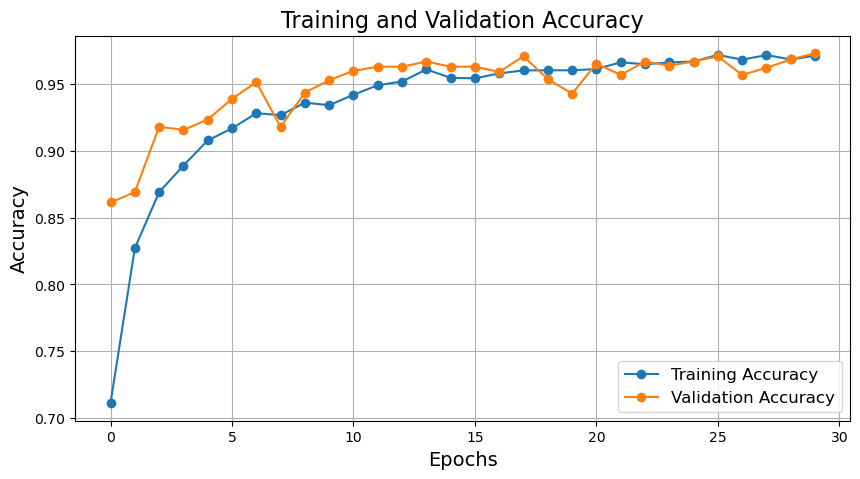

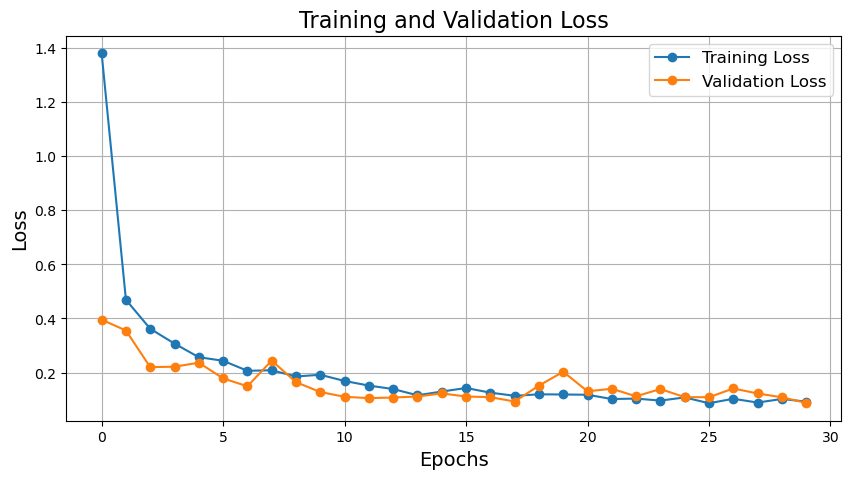

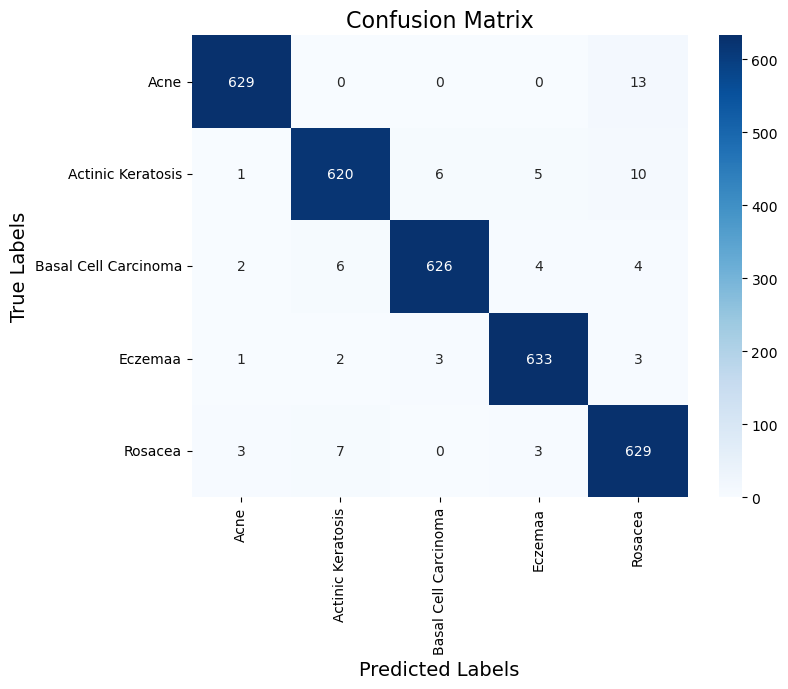

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()
